In [304]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils
import dvu
dvu.set_style()
cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [305]:
from typing import Dict
import pickle

# load suffix stuff
suffix_results = pickle.load(open('../results/prompt_gen/results_suffix_math.pkl', 'rb'))
SUFFIX_LEGEND_REMAP = {
    'Single-query': 'Suffix, single-output decoding',
    'Avg suffix': 'Suffix, average-output decoding',
}
suffix_results['legend'] = suffix_results['use_single_query'].map(
            SUFFIX_LEGEND_REMAP) + ' (' + suffix_results['n_shots'].astype(str) + '-Ex.)'
suffix_results['do_reranking'] = False
suffix_results['reciprocal_rank'] = suffix_results['final_answer_pos_initial_token'].map(lambda n: 1/(n+1))


# drop results for other models, n_shots == 10, single-query ones.
suffix_results = suffix_results[
      (suffix_results["checkpoint"] == "EleutherAI/gpt-j-6B")
    & (suffix_results["n_shots"] < 10)
    & (suffix_results["use_single_query"] == "Avg suffix")
]

def fix_legend__suffix(s: str) -> str:
    return s.replace('1-Ex.', 'Zero-shot').replace('5-Ex.', '4-shot')
suffix_results["legend"] = suffix_results["legend"].map(fix_legend__suffix)

In [306]:
suffix_results["legend"]

41     Suffix, average-output decoding (Zero-shot)
35        Suffix, average-output decoding (4-shot)
37     Suffix, average-output decoding (Zero-shot)
43        Suffix, average-output decoding (4-shot)
48     Suffix, average-output decoding (Zero-shot)
33        Suffix, average-output decoding (4-shot)
49     Suffix, average-output decoding (Zero-shot)
53        Suffix, average-output decoding (4-shot)
61     Suffix, average-output decoding (Zero-shot)
64        Suffix, average-output decoding (4-shot)
0         Suffix, average-output decoding (4-shot)
9      Suffix, average-output decoding (Zero-shot)
28        Suffix, average-output decoding (4-shot)
76     Suffix, average-output decoding (Zero-shot)
98     Suffix, average-output decoding (Zero-shot)
92        Suffix, average-output decoding (4-shot)
107    Suffix, average-output decoding (Zero-shot)
94        Suffix, average-output decoding (4-shot)
82        Suffix, average-output decoding (4-shot)
99     Suffix, average-output d

In [307]:
suffix_results[['checkpoint',  'task_name', 'n_shots']].value_counts()

checkpoint           task_name      n_shots
EleutherAI/gpt-j-6B  add_two        1          1
                                    5          1
                     subtract_two   1          1
                     square_one     5          1
                                    1          1
                     multiply_two   5          1
                                    1          1
                     max_two        5          1
                                    1          1
                     first_two      5          1
                                    1          1
                     fibonacci_one  5          1
                                    1          1
                     exp_one        5          1
                                    1          1
                     double_one     5          1
                                    1          1
                     divide_two     5          1
                                    1          1
                     subt

In [308]:
from typing import Dict

nice_method_names = {
    'autoprompt': 'AutoPrompt',
    'genetic': 'EvoPrompt',
}
def get_legend__autoprompt(row: Dict) -> str:
    nss = 'Zero-shot' if row['n_shots'] == 1 else f'{row["n_shots"]-1}-shot'
    return nice_method_names.get(row["model_cls"]) + f' ({nss})'


autoprompt_save_dir = '/home/johnmorris/interpretable-autoprompting/results/autoprompt_arithmetic'

raw_autoprompt_results = analyze_utils.load_results_and_cache_autoprompt_json(autoprompt_save_dir, save_file='r.pkl')
autoprompt_results = raw_autoprompt_results.groupby(['model_cls', 'task_name', 'n_shots', 'num_learned_tokens']).first().reset_index()
autoprompt_results = autoprompt_results[autoprompt_results["num_learned_tokens"] == 6]
autoprompt_results["legend"] = autoprompt_results.apply(get_legend__autoprompt, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 115.79it/s]


/home/johnmorris/interpretable-autoprompting/notebooks/analyze_utils.py:348: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


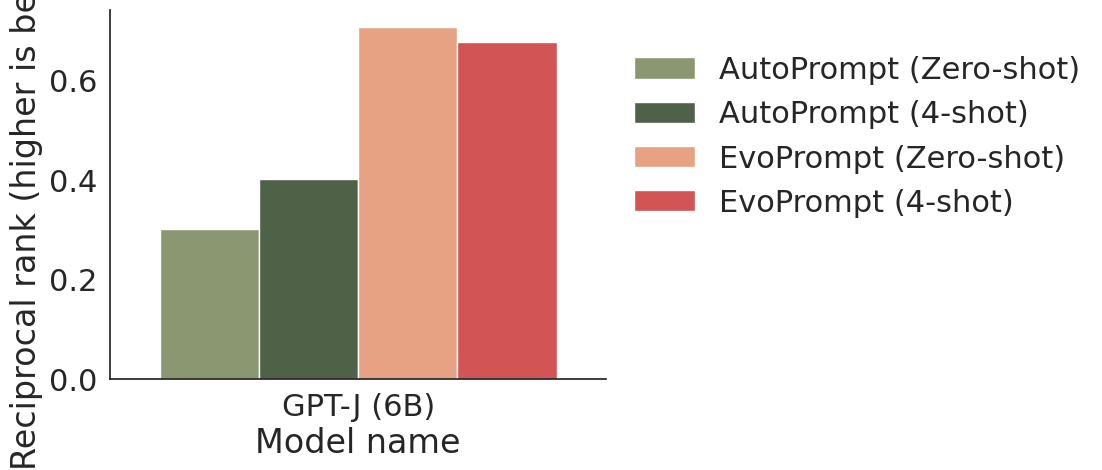

In [309]:
# metric_key = 'final_answer_pos_initial_token'
# metric_key = f'Recall @ {5} suffixes'
metric_key = 'reciprocal_rank'
tab = (
    (autoprompt_results
        # (mean over templates, task_name)
        .groupby(['checkpoint', 'legend'])[[metric_key]]
        .mean()
        .reset_index()
    )
)
analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)

In [310]:
r = pd.concat((suffix_results, autoprompt_results), axis=0)

pd.set_option('display.max_rows', 100)

r.groupby(["legend", "task_name", "n_shots"])[["reciprocal_rank", "prefixes", "max_digit"]].first()

reciprocal_rank  \
legend                                      task_name     n_shots                    
AutoPrompt (4-shot)                         add_two       5               1.000000   
                                            divide_two    5               0.000100   
                                            double_one    5               0.000100   
                                            exp_one       5               0.010101   
                                            fibonacci_one 5               0.000100   
                                            first_two     5               1.000000   
                                            max_two       5               0.000100   
                                            multiply_two  5               1.000000   
                                            square_one    5               0.000100   
                                            subtract_two  5               1.000000   
AutoPrompt (Zero-shot)                      add_two       1               1.000000   
                                            divide_two    1               0.000100   
                                            double_one    1               0.000100   
                                            exp_one       1               0.009009   
                                            fibonacci_one 1               0.000100   
                                            first_two     1               0.000100   
                                            max_two       1               0.000100   
                                            multiply_two  1               1.000000   
                                            square_one    1               0.000100   
                                            subtract_two  1               1.000000   
EvoPrompt (4-shot)                          add_two       5               1.000000   
                                            divide_two    5               0.000100   
                                            double_one    5               1.000000   
                                            exp_one       5               0.000100   
                                            fibonacci_one 5               0.500000   
                                            first_two     5               1.000000   
                                            max_two       5               1.000000   
                                            multiply_two  5               1.000000   
                                            square_one    5               0.250000   
                                            subtract_two  5               1.000000   
EvoPrompt (Zero-shot)                       add_two       1               1.000000   
                                            divide_two    1               0.055556   
                                            double_one    1               1.000000   
                                            exp_one       1               0.000100   
                                            fibonacci_one 1               0.000100   
                                            first_two     1               1.000000   
                                            max_two       1               1.000000   
                                            multiply_two  1               1.000000   
                                            square_one    1               1.000000   
                                            subtract_two  1               1.000000   
Suffix, average-output decoding (4-shot)    add_two       5               1.000000   
                                            divide_two    5               1.000000   
                                            double_one    5               0.021277   
                                            exp_one       5               0.007519   
                                            fibonacci_one 5               0.012195   
                         

In [312]:
tn = r[["task_name"]].value_counts().reset_index()
finished_task_names = tn[tn[0]==tn[0].max()]["task_name"].tolist()
rf = r[r["task_name"].map(lambda t: t in finished_task_names)] # r_finished

In [313]:
len(r), len(rf)

(60, 60)

In [314]:
len(suffix_results), len(autoprompt_results)

(20, 40)

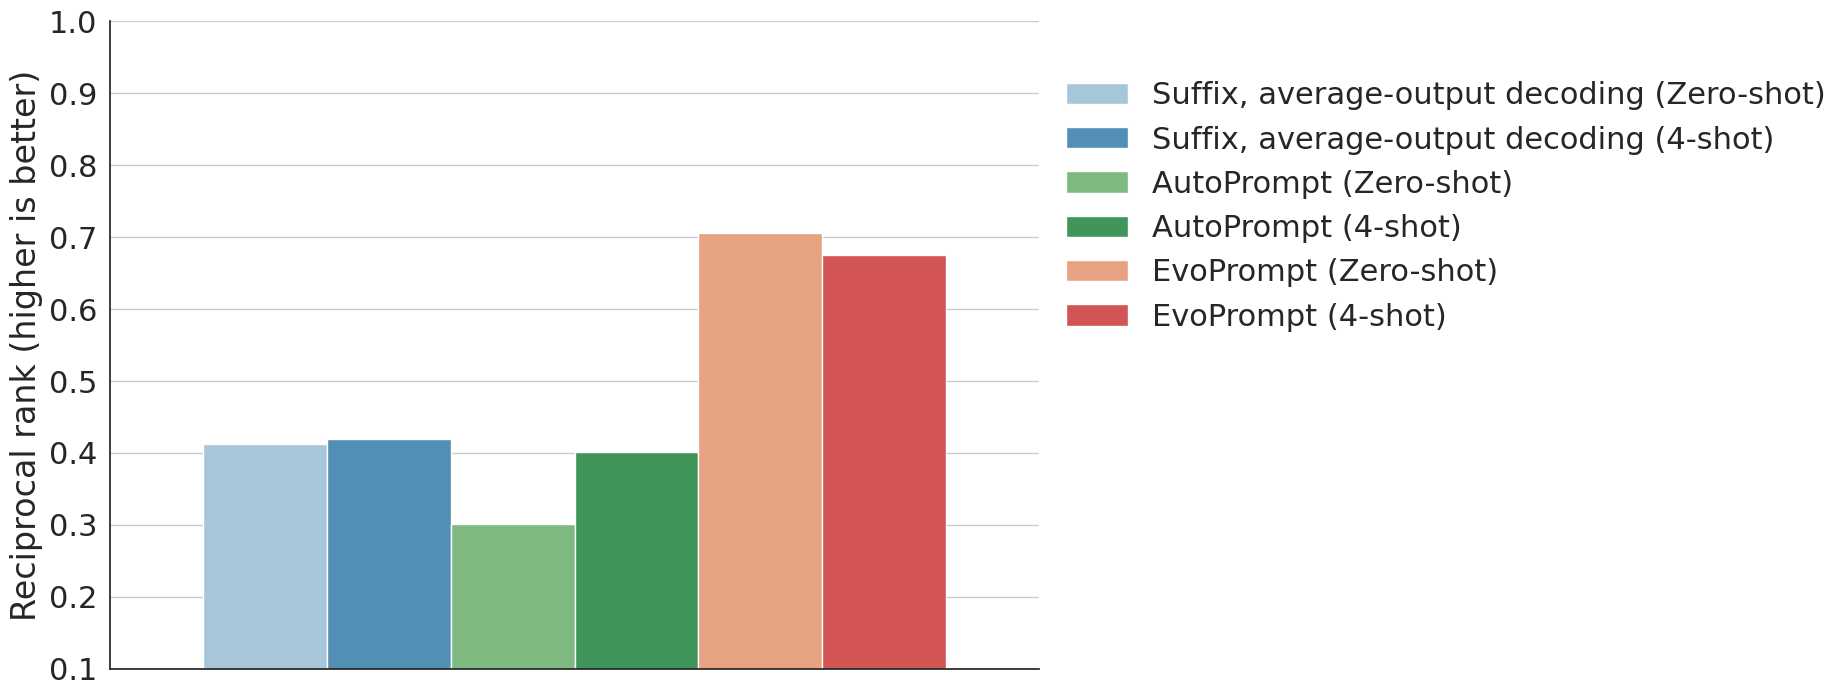

In [318]:
for metric_key in [
                 'reciprocal_rank',
                #  'final_answer_pos_initial_token',
                #  f'Recall @ {3} suffixes',
                #    f'Recall @ {10} suffixes', 
                #    f'Recall @ {100} suffixes',
                   ]:
    plt.figure(figsize=(19, 8))
    # plt.figure(figsize=(10, 3.5))
    tab = ((r
            # (mean over templates, task_name)
            .groupby(['checkpoint', 'legend', 'n_shots'])[[metric_key]]
            .mean()
            .reset_index()
        )
    )
    analyze_utils.plot_tab(tab, metric_key=metric_key, title='ANLI datasets', add_legend=False)
    plt.xticks([])
    plt.xlabel('')
    plt.grid()
    plt.ylim((0.1, 1.0))
    if metric_key == 'reciprocal_rank':
        plt.savefig('../results/prompt_gen/joint_math_barplot.pdf', bbox_inches='tight')
        tab.to_pickle(f'../results/prompt_gen/tab_joint_math_{metric_key}.pkl')
    # plt.legend('', frameon=False)
    plt.show()

### Plot the best model

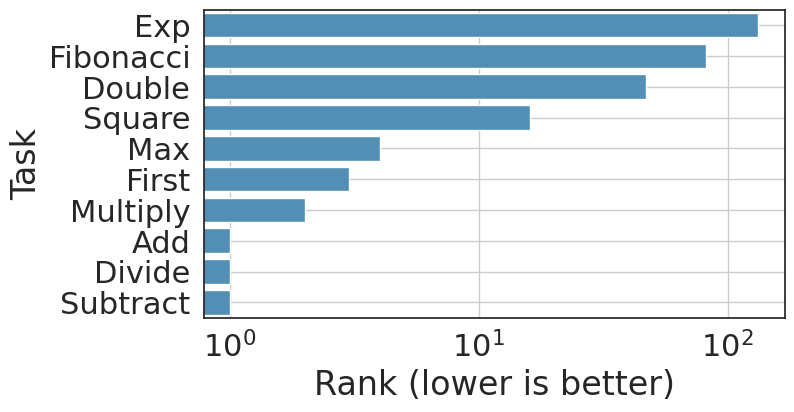

In [185]:
r['rank'] = r['final_answer_pos_initial_token'] + 1

def plot_model(legend_name: str):
    sns.set(style="white", font_scale=2)
    plt.figure(figsize=(7.5, 4))
    model_results = (
        r[(r['legend'] == legend_name) & (r['checkpoint'] == 'EleutherAI/gpt-j-6B')].reset_index()
            .sort_values(by='rank', ascending=False)
    )

    sns.barplot(data=model_results, y=model_results['task_name'].map(lambda x: x.split('_')[0].capitalize()), x='rank', color=analyze_utils.COLORS[legend_name]) 
    plt.grid()
    plt.xticks([1, 10, 100], labels=['1', '10', '100'])
    plt.gca().set_xscale('log')
    plt.xlabel('Rank (lower is better)')
    plt.ylabel('Task')
    
    # sns.barplot(data=model_results, y='task_name', x='rank', color=analyze_utils.COLORS[legend_name])
    # plt.gca().set_xscale('log')
    # plt.xlabel('Rank')
    # plt.ylabel('Task')
    
    
# plot_model(legend_name='Prefix, average-output (1-Ex.)')
plot_model(legend_name='Suffix, average-output decoding (4-shot)')
plt.savefig('../results/prompt_gen/best_rank_math.pdf', bbox_inches='tight')
# plot_model(legend_name='Suffix, average-output decoding (10-Ex.)')

In [21]:
r[r['legend'] == 'Suffix, average-output decoding (5-Ex.)'].reset_index()['task_name'].value_counts()

fibonacci_one    4
square_one       4
double_one       4
exp_one          4
multiply_two     4
max_two          4
add_two          4
divide_two       4
first_two        4
subtract_two     4
Name: task_name, dtype: int64